# Mean Shift
Mean Shift ищет моды плотности, сдвигая точки к максимумам ядровой оценки плотности. Итерация сдвига: $x^{(t+1)} = \frac{\sum_i K\left(\frac{||x^{(t)}-x_i||^2}{h^2}\right) x_i}{\sum_i K\left(\frac{||x^{(t)}-x_i||^2}{h^2}\right)}$, где $K$ — ядро, $h$ — ширина окна. Точки, сходящиеся к одному максимуму, образуют кластер. Число кластеров определяется автоматически.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `make_blobs`, `StandardScaler`, `MeanShift`, `estimate_bandwidth`, `silhouette_score`.


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score


In [18]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Синтетический датасет из 350 точек вокруг 3 центров (`cluster_std=1.0`). Используем синтетику, чтобы знать ожидаемое число кластеров (3) и проверить, что Mean Shift их автоматически находит без явного задания `n_clusters`.


In [19]:
X, _ = make_blobs(
    n_samples=350,
    centers=3,
    cluster_std=1.0,
    random_state=42,
)

data = pd.DataFrame(X, columns=["feature_1", "feature_2"])
print(f"Размерность: {data.shape}")
data.head()


Размерность: (350, 2)


,feature_1,feature_2
0,-2.412120,9.982931
1,-7.670102,-6.408641
2,-0.623012,9.188864
3,5.351494,0.848528
4,5.945358,1.994174


## Предварительная обработка
Стандартизируем данные. Ширина окна `h` в Mean Shift задаётся в пространстве признаков — масштаб данных напрямую влияет на `estimate_bandwidth`. После стандартизации `quantile=0.3` даёт адекватную оценку ширины окна.


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)


## Тепловая карта корреляций
При генерации через `make_blobs` два признака независимы — корреляция близка к нулю. Это подтверждает, что синтетические данные не вносят структурную зависимость между осями.


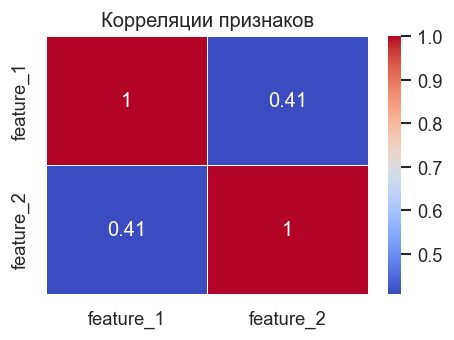

In [21]:
plt.figure(figsize=(4, 3))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков")
plt.tight_layout()
plt.show()


## Обучение модели
`estimate_bandwidth(X_scaled, quantile=0.3)` оценивает ширину окна по квантилям расстояний. `bin_seeding=True` ускоряет алгоритм: начальные центры берутся из сетки, а не из каждой точки. Mean Shift гарантированно сходится, но медленнее k-means.


In [22]:
bandwidth = estimate_bandwidth(X_scaled, quantile=0.3)
model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
model.fit(X_scaled)


MeanShift(bandwidth=np.float64(0.5082337575016915), bin_seeding=True)

## Прогнозы модели
Число кластеров определено автоматически. Silhouette Score показывает качество разбиения. Если `quantile` слишком мал, алгоритм найдёт много микрокластеров; слишком велик — сольёт все точки в один.


In [23]:
labels = model.labels_

if len(np.unique(labels)) > 1:
    score = silhouette_score(X_scaled, labels)
else:
    score = float("nan")

print("Mean Shift")
print(f"Clusters: {len(np.unique(labels))}")
print(f"Silhouette: {score:.3f}")


Mean Shift
Clusters: 3
Silhouette: 0.845


## Графики выходных результатов
**Scatter-график с центрами.** Оранжевые крестики — найденные центры мод (cluster centers). Идеально: три цветных облака и три крестика в центре каждого. Центры Mean Shift лежат точно в максимуме плотности кластера.


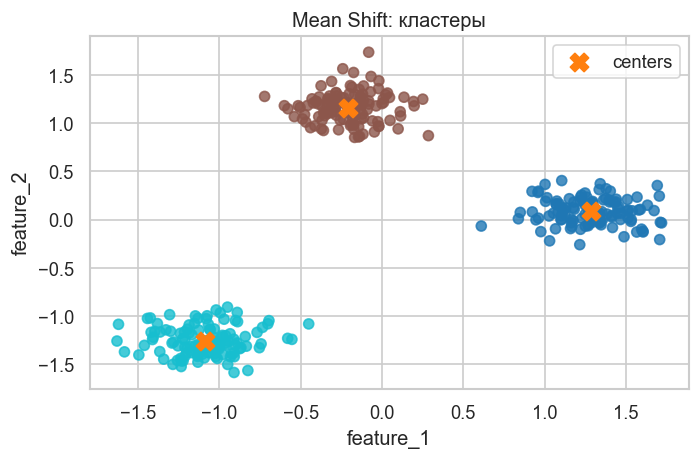

In [24]:
plt.figure(figsize=(6, 4))
plt.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=labels,
    cmap="tab10",
    alpha=0.8,
)
centers = model.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    s=120,
    color=SECONDARY_COLOR,
    marker="X",
    label="centers",
)
plt.title("Mean Shift: кластеры")
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.legend()
plt.tight_layout()
plt.show()
